<h1>Imports y Configuraciones Iniciales</h1>

In [9]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU
from PIL import Image
import pandas as pd

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

In [10]:
TIPO_IMAGENES = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'

# configurar los directorios de las imágenes

TRAIN_DIR = r"C:\Users\54934\Downloads\train"
TEST_DIR = r"C:\Users\54934\Downloads\test"

SIZE = 128

In [11]:
images_reader = ImageDataGenerator(
    rescale=1/255,  # Normaliza los píxeles a valores entre 0 y 1
    rotation_range=20,  # Rotar imágenes aleatoriamente entre 0 y 20 grados
    width_shift_range=0.2,  # Desplazar horizontalmente hasta el 20% del ancho
    height_shift_range=0.2,  # Desplazar verticalmente hasta el 20% de la altura
    shear_range=0.2,  # Cortar (shear) imágenes aleatoriamente
    zoom_range=0.2,  # Ampliar imágenes aleatoriamente
    horizontal_flip=True,  # Voltear imágenes horizontalmente
    fill_mode='nearest',  # Estrategia para rellenar nuevos píxeles
    brightness_range=(0.5, 1.5),  # Cambiar brillo aleatoriamente
    validation_split=0.2  # Porcentaje para la validación (20%)
)

READ_PARAMS = dict(
    class_mode="categorical",
    classes=TIPO_IMAGENES, # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE), # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    batch_size=32, # Tamaño del lote
)

In [12]:
# Generador para entrenamiento (80%)
train = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='training',
    **READ_PARAMS
)

# Generador para validación (20%)
validation = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    **READ_PARAMS
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [13]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(TIPO_IMAGENES[np.argmax(labels[i])])
        plt.axis("off")

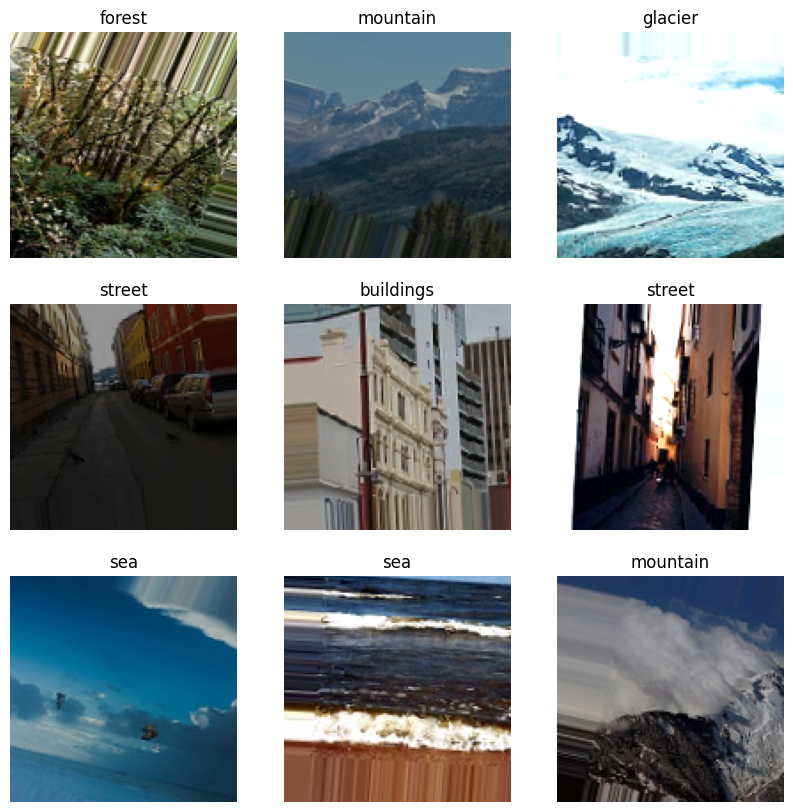

In [14]:
sample_images(train)

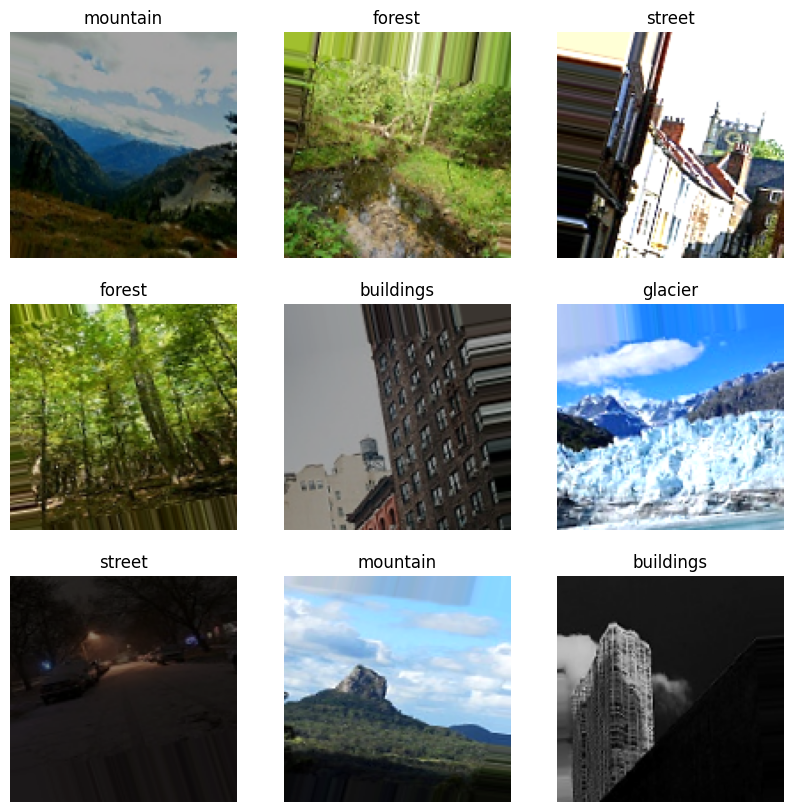

In [15]:
sample_images(validation)

<h1>Análisis Exploratorio del conjunto de datos</h1>

<h2> Estructura y Formato </h2>

In [10]:
# Funcion que devuelve la estructura de 10 imágenes random de cada subcarpeta del dataset de train
import random
def image_structure_info(dataset_dir, num_examples=10):
    for root, _, files in os.walk(dataset_dir):
        if files:
            print(f"Subcarpeta: {os.path.relpath(root, dataset_dir)}")
            random_files = random.sample(files, min(num_examples, len(files)))
            for file in random_files:
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                image_format = image.format
                image_size = image.size
                print(f"- Nombre: {file}, Formato: {image_format}, Tamaño: {image_size}")

image_structure_info(TRAIN_DIR, num_examples=10)

Subcarpeta: buildings
- Nombre: 19973.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 16079.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 6685.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 12659.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 17457.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 2088.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 6505.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 2735.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 10032.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 19325.jpg, Formato: JPEG, Tamaño: (150, 150)
Subcarpeta: forest
- Nombre: 277.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 6016.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 11354.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 1285.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 6836.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 12621.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 16817.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 1968.jpg, Formato: JPEG

<h3> Observaciones </h3>

Las imágenes en cada subcarpeta siguen un formato consistente (JPEG de 150x150 píxeles). Esto simplifica el preprocesamiento, ya que todas las imágenes tienen un tamaño uniforme, permitiendo entrenar el modelo sin necesidad de redimensionamiento adicional, a menos que se opte por reducir el tamaño para mejorar los tiempos de procesamiento.

<h2> Volumetría </h2>

In [11]:
# Funcion que devuelve la volumetria en los datos en el dataset de train
def dataset_volumetrics(dataset):
    num_samples = 0
    class_counts = {}
    
    for root, _, files in os.walk(dataset.directory):
        if files:
            class_name = os.path.basename(root)
            num_images = len(files)
            num_samples += num_images
            class_counts[class_name] = num_images
    
    num_classes = len(class_counts)
    
    return num_samples, num_classes, class_counts

num_samples, num_classes, class_counts = dataset_volumetrics(train)
print(f"Número total de muestras en el dataset: {num_samples}")
print(f"Número de clases en el dataset: {num_classes}")
print("Cantidad de muestras por clase:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

Número total de muestras en el dataset: 14034
Número de clases en el dataset: 6
Cantidad de muestras por clase:
- buildings: 2191
- forest: 2271
- glacier: 2404
- mountain: 2512
- sea: 2274
- street: 2382


<h3> Observaciones </h3>

Con un total de 14,034 imágenes en el conjunto de entrenamiento, el dataset tiene un tamaño suficiente para experimentar con modelos de redes neuronales profundas como CNNs.

<h2> Distribución de la Variable a predecir </h2>

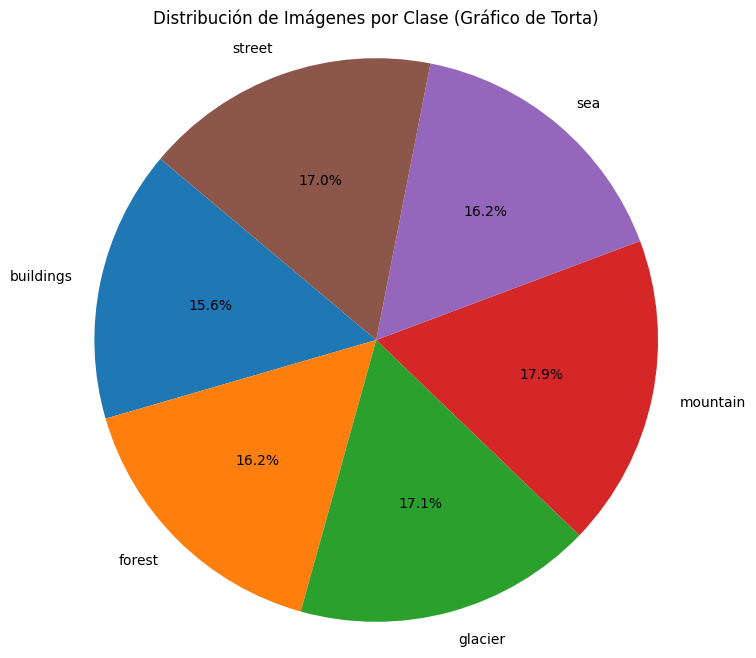

Información adicional:
Número total de clases: 6
Número total de imágenes: 14034
Clases con mayor cantidad de imágenes:
- mountain: 2512 imágenes
- glacier: 2404 imágenes
- street: 2382 imágenes
- sea: 2274 imágenes
- forest: 2271 imágenes


In [12]:
def plot_image_distribution_pie(dataset_dir):
    class_counts = {}
    
    for root, _, files in os.walk(dataset_dir):
        if files:
            class_name = os.path.basename(root)
            num_images = len(files)
            class_counts[class_name] = num_images
    
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Distribución de Imágenes por Clase (Gráfico de Torta)')
    plt.show()
    
    print("Información adicional:")
    print(f"Número total de clases: {len(class_counts)}")
    print(f"Número total de imágenes: {sum(class_counts.values())}")
    print("Clases con mayor cantidad de imágenes:")
    sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    for class_name, count in sorted_class_counts[:5]:
        print(f"- {class_name}: {count} imágenes")

# Llamar a la función con tu directorio de dataset
plot_image_distribution_pie(TRAIN_DIR)

<h3> Observaciones </h3>

La distribución de imágenes por clase es bastante balanceada, aunque algunas clases, como mountain y glacier, presentan una cantidad levemente superior de muestras. Esto sugiere que el modelo debería recibir una representación adecuada de cada categoría, lo cual es favorable para el entrenamiento, ya que reduce el riesgo de sesgo hacia una clase específica.

<h1> Modelado </h1>

In [13]:
input_shape = (SIZE, SIZE, 3)

<h2>MLP Simple</h2>

Probamos como primer modelo el MLP Simple, con una capa densa de 500 neuronas, y una funcion de activación "tanh", entrenamos 5 épocas.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               24576500  
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3006      
Total params: 24,579,506
Trainable params: 24,579,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
351/351 [==============================] - 68s 193ms/step - loss: 2.4105 - accuracy: 0.1823 - val_loss: 1.7925 - val_accuracy: 0.2425
Epoch 2/5
351/351 [==============================] - 62s 178ms/step - loss: 1.9388 - accuracy: 0.1

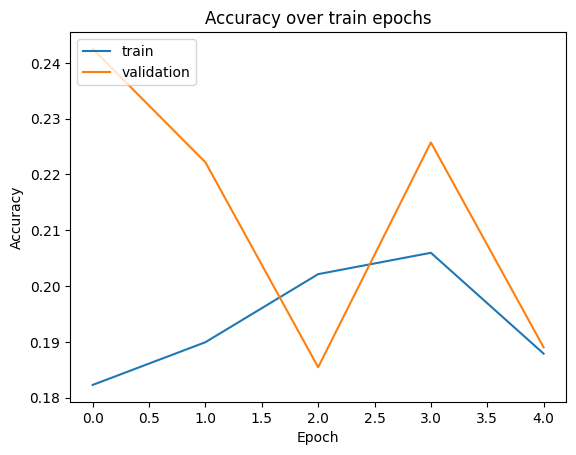

In [11]:
# MLP simple
model_mlp = Sequential([
    
    Input(input_shape),    
    Flatten(),
    Dense(500, activation='tanh'),
    Dropout(0.25),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_mlp.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_mlp.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Conclusión</h3>

Este modelo tiene limitaciones significativas al trabajar directamente con imágenes, pues no aprovecha características espaciales como un modelo convolucional. Los resultados reflejan una precisión baja comparada con estos modelos.

Un MLP simple no es adecuado para clasificación de imágenes porque:

- Pierde la estructura espacial: Al aplanar las imágenes, no capta relaciones entre píxeles cercanos, perdiendo patrones importantes.
- Escala mal: Requiere demasiados parámetros y recursos computacionales al manejar imágenes grandes.
- No aprende características complejas: A diferencia de las CNN, no detecta características jerárquicas, esenciales para identificar objetos en imágenes.
- Las CNN son mejores porque capturan relaciones espaciales y patrones complejos de forma más eficiente.

<h2>Modelo Convolucional</h2>

Seguidamente probamos el modelo con dos capas convolucionales con activación ReLU y capas de dropout para reducir el overfitting, seguidas de una capa de max pooling para reducir la dimensionalidad. Después de aplanar los datos, empleamos una capa totalmente conectada con activación tanh y otra capa de dropout.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 10)      490       
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 10)      1610      
_________________________________________________________________
dropout_2 (Dropout)          (None, 122, 122, 10)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

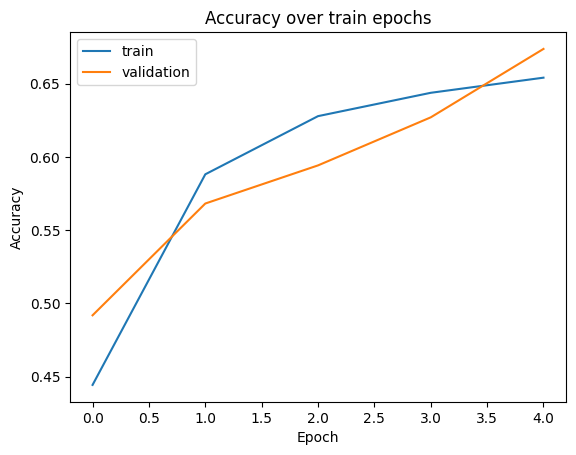

In [12]:
# Convolucional
model_convolucional = Sequential([
    
    Input(input_shape),
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),  
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),   
    MaxPooling2D(pool_size=(4, 4)),  
    Flatten(),    
    Dense(100, activation='tanh'),
    Dropout(0.25),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Conclusión</h3>

Con una precisión del 67%, el modelo tiene un desempeño moderado, indicando que la arquitectura actual podría ser insuficiente para capturar todos los patrones necesarios. Ajustar el número de capas y neuronas, o probar con más filtros, podría mejorar su capacidad de generalización y aumentar la precisión.

<h1>Modelo Convolucional con mas Capas</h1>

Después de obtener un rendimiento del 67% con el modelo anterior, probamos una arquitectura más profunda con más capas convolucionales para mejorar la capacidad del modelo de extraer características complejas de las imágenes. Este nuevo modelo incluye tres capas convolucionales con un número creciente de filtros (32, 64 y 128), seguidas de capas de max pooling para reducir la dimensionalidad. Posteriormente, se añaden dos capas densas antes de la capa de salida con activación softmax, lo que permite una clasificación más precisa de las imágenes.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)            

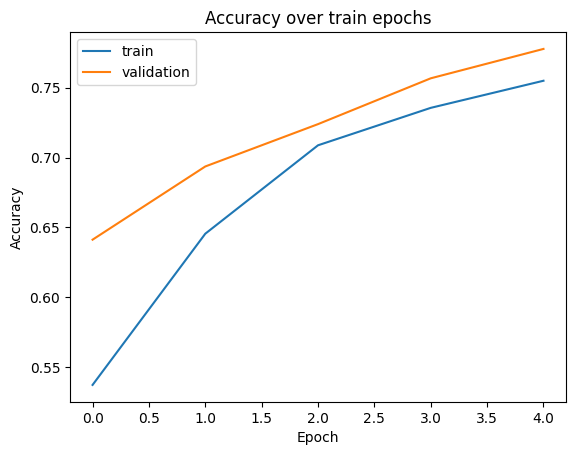

In [13]:
# Convolucional con mas capas
model_convolucional_mas_capas = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(TIPO_IMAGENES), activation='softmax')
])

model_convolucional_mas_capas.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_mas_capas.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_mas_capas.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Conclusión</h3>

Con una precisión del 77%, el modelo con más capas muestra una mejora significativa en comparación con el anterior. Esto sugiere que una mayor profundidad y la adición de más filtros en las capas convolucionales ayudan al modelo a aprender características más complejas y a generalizar mejor. A pesar de la mejora, aún podría haber margen para optimizar el modelo, explorando ajustes adicionales en los hiperparámetros.

<h1>Modelo Convolucional con VGG16</h1>

Después de experimentar con diferentes arquitecturas, probamos un modelo basado en la red preentrenada VGG16 para aprovechar las características aprendidas en grandes conjuntos de datos. Utilizamos VGG16 sin la capa superior, congelando sus pesos para que no se entrenen nuevamente. Luego, añadimos capas densas con activación tanh para refinar las predicciones y, finalmente, una capa de salida con activación softmax. Este enfoque permite aprovechar el poder de un modelo preentrenado para mejorar el rendimiento en un conjunto de datos más específico.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 606       
Total params: 15,544,694
Trainable params: 830,006
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/5
351/351 [==============================] - 246s 699ms/step - loss: 0.6666 - accuracy: 0.7532

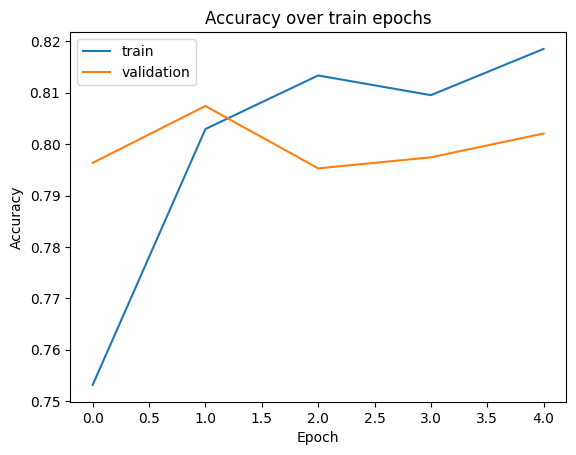

In [17]:
# Convolucional usando convoluciones ya entrenadas de VGG16, con funcion de activacion "tanh"
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_vgg16_tanh = Sequential([
    
    pretrained_model,
    Flatten(),
    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_vgg16_tanh.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_vgg16_tanh.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_vgg16_tanh.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Conclusión</h3>

Con una precisión aproximada del 81%, el modelo basado en VGG16 preentrenado muestra una mejora significativa respecto a las versiones anteriores. Esto confirma que el uso de una red preentrenada permite aprovechar características ya aprendidas de grandes conjuntos de datos, mejorando la capacidad del modelo para generalizar. Aunque la precisión es considerable, aún hay espacio para mejorar.

<h1>Modelo Convolucional con VGG16 utilizando función de activación "LeakyRelu"</h1>

Luego de experimentar con el modelo VGG16 preentrenado utilizando la función de activación tanh, probamos una variante con LeakyReLU para mejorar la capacidad de activación y mitigar el problema del vanishing gradient. Este modelo también emplea capas de dropout para prevenir el overfitting y, como en el anterior, se utilizo VGG16 sin la capa superior y con sus pesos congelados. La estructura de capas densas con LeakyReLU permite una mayor flexibilidad en el aprendizaje de características complejas.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

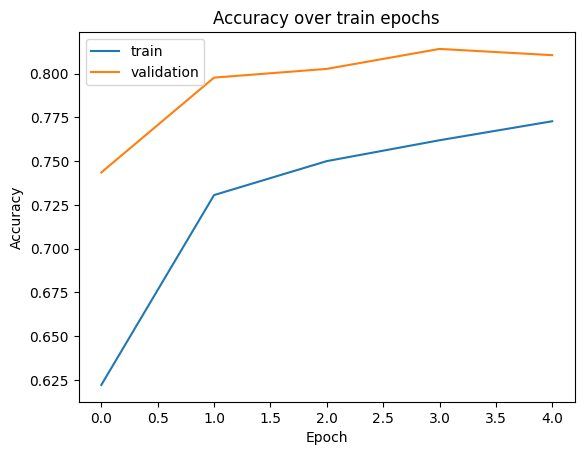

In [15]:
# Convolucional usando convoluciones ya entrenadas de VGG16 con funcion de activacion "leakyrelu"
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_mas_capas_LeakyReLU = Sequential([
    
    pretrained_model,   
    Flatten(),
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),
    Dense(128, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_mas_capas_LeakyReLU.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_mas_capas_LeakyReLU.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_mas_capas_LeakyReLU.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Conclusión</h3>

Con una precisión del 81.7%, el modelo con LeakyReLU muestra una ligera mejora respecto al modelo anterior. Esta leve mejora indica que el uso de LeakyReLU en lugar de tanh permitió una activación más eficiente, especialmente en redes profundas, ayudando a superar problemas de vanishing gradient y acelerando el aprendizaje. Aunque el rendimiento es sólido, aún podría haber espacio para optimizar el modelo.

<h1>Modelo Convolucional basado en la arquitectura Xception con funcion de activación LeakyRelu</h1>

Después de probar modelos anteriores, implementamos un modelo basado en la arquitectura Xception, con una red convolucional eficiente y profunda que ha mostrado buenos resultados en tareas de clasificación de imágenes. Para este modelo, utilizamos la función de activación LeakyReLU para mejorar el flujo de gradientes y evitar problemas de desactivación de neuronas. Probamos con 10 épocas.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                

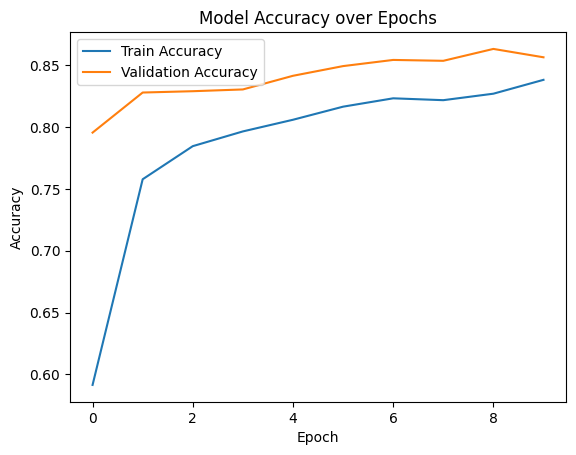

In [26]:
# Modelo Xception con funcion de activacion leakyrelu, imagenes reescaladas y 10 epocas
input_shape = (150, 150, 3)  
batch_size = 128            
num_classes = len(TIPO_IMAGENES)  

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

pretrained_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')
pretrained_model.trainable = False  

model_xception = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),  
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),
    Dense(128, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_xception.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_xception.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

history = model_xception.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=[OurCustomCallback(), early_stopping, lr_scheduler]
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Conclusión</h3>

Con una precisión del 86.3%, el modelo basado en Xception muestra una mejora significativa en comparación con los modelos anteriores. Esto indica que la arquitectura Xception, junto con el uso de LeakyReLU y las transformaciones de aumento de datos, ha sido eficaz para mejorar el rendimiento del modelo, ayudando a captar mejor las características relevantes de las imágenes. La combinación de una red preentrenada avanzada y técnicas de aumento de datos ha permitido una mayor capacidad de generalización.

<h1>Conclusión Final</h1>

En general, las pruebas realizadas muestran que el rendimiento del modelo mejora significativamente al utilizar arquitecturas más complejas y técnicas adicionales como redes preentrenadas y funciones de activación más eficaces.

- Modelos más simples (como el MLP y el modelo convolucional básico) tienen limitaciones en la captura de características complejas y, por ende, un rendimiento más bajo.
- Mayor profundidad en la red (agregando más capas convolucionales o neuronas) incrementa la capacidad del modelo para aprender patrones complejos, lo que resultó en una mejora en la precisión (del 67% al 77%).
- Uso de modelos preentrenados (como VGG16) aprovechando las características aprendidas de grandes bases de datos mejoró considerablemente la precisión (alrededor del 81%), lo que demuestra que las redes preentrenadas son muy útiles para transferir conocimientos a conjuntos de datos más pequeños o específicos.
- Aumento de datos y uso de arquitecturas avanzadas como Xception mostró el mejor rendimiento (86.3%), confirmando que técnicas de regularización, como el aumento de datos, y arquitecturas más sofisticadas, ayudan a mejorar la generalización y evitar el overfitting.

En conclusión, para lograr una clasificación de imágenes más precisa, es crucial combinar modelos más profundos, redes preentrenadas, funciones de activación eficientes como LeakyReLU y técnicas de aumento de datos. Esto maximiza la capacidad de aprender de características complejas y generalizar mejor a nuevos datos. Sin embargo, siempre queda espacio para ajustar y optimizar aún más estos modelos para alcanzar el rendimiento máximo.

<h1>Dificultades</h1>

Durante el desarrollo del trabajo y entrenamiento de los modelos, nos encontramos con varias dificultades que afectaron tanto el rendimiento como la eficiencia del proceso:

- Uso de CPU en lugar de GPU: A pesar de los planes iniciales de utilizar la GPU, los algoritmos fueron ejecutados con CPU, lo que aumentó significativamente los tiempos de entrenamiento. Esto dificultó la experimentación con modelos más complejos, ya que los tiempos de entrenamiento largos retrasaron la optimización de los modelos y la prueba de diferentes configuraciones.
- Selección de Parámetros: Elegir los parámetros correctos, como el número de capas, neuronas, tasa de dropout, tamaño de batch y tasa de aprendizaje, fue un desafío. A pesar de contar con algunas intuiciones, se requirieron múltiples iteraciones y ajustes para encontrar las configuraciones óptimas. Este proceso consumió una cantidad considerable de tiempo y recursos computacionales.
- Investigación de Arquitecturas: La selección de arquitecturas adecuadas también fue un reto, especialmente al intentar decidir entre usar modelos preentrenados o construir redes desde cero. La exploración de diversas arquitecturas, como VGG16, Xception y redes convolucionales más simples, requirió una investigación detallada sobre sus fortalezas, limitaciones y compatibilidad con el conjunto de datos disponible. El tiempo dedicado a investigar y probar diferentes arquitecturas fue significativo, y algunos enfoques no dieron los resultados esperados, lo que prolongó el proceso de optimización.

Estas dificultades fueron parte del aprendizaje y ajuste del modelo, y aunque ralentizaron el progreso, también proporcionaron valiosas lecciones sobre la importancia de la optimización de recursos y la experimentación cuidadosa con parámetros y arquitecturas.

<h1>Nuestras Predicciones</h1>

In [48]:
print(len(model_weights_at_epochs))  # Para verificar cuántos elementos tiene la lista o diccionario

10


In [49]:
# nos podemos quedar con los mejores pesos, o dejarlos como están después de la última epoch
model_xception.set_weights(model_weights_at_epochs[8])

In [50]:
from IPython.display import Image, display

def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(150, 150)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model_xception.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", TIPO_IMAGENES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

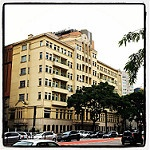

Prediction: buildings
Prediction detail: [[9.9795026e-01 1.1466735e-13 1.4624779e-13 1.6359690e-12 2.0498030e-03
  7.2036928e-09]]


In [53]:
show_and_predict(r"C:\Users\54934\Downloads\test\20555.jpg")

<h1>Para subir a Kaggle</h1> 

In [54]:
"""
# Configuracion para subir el último modelo, si queremos subir otro hay que modificar el "Target_size" por (SIZE, SIZE).
CSV_FILENAME = "Resultados"
MODEL = model_xception

images = []
labels = []

for image in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, image)
    image_array = img_to_array(load_img(image_path, target_size=(150, 150)))
    images.append(image_array)

inputs = np.array(images) / 255.0

predictions = MODEL.predict(inputs)

for i, filename in enumerate(os.listdir(TEST_DIR)):
    predicted_label = TIPO_IMAGENES[np.argmax(predictions[i])]
    labels.append([filename, predicted_label])

df = pd.DataFrame(labels, columns=["ID", "Label"])
df.to_csv(CSV_FILENAME+".csv", index=False)
"""

'\n# Configuracion para subir el último modelo, si queremos subir otro hay que modificar el "Target_size" por (SIZE, SIZE).\nCSV_FILENAME = "Resultados"\nMODEL = model_xception\n\nimages = []\nlabels = []\n\nfor image in os.listdir(TEST_DIR):\n    image_path = os.path.join(TEST_DIR, image)\n    image_array = img_to_array(load_img(image_path, target_size=(150, 150)))\n    images.append(image_array)\n\ninputs = np.array(images) / 255.0\n\npredictions = MODEL.predict(inputs)\n\nfor i, filename in enumerate(os.listdir(TEST_DIR)):\n    predicted_label = TIPO_IMAGENES[np.argmax(predictions[i])]\n    labels.append([filename, predicted_label])\n\ndf = pd.DataFrame(labels, columns=["ID", "Label"])\ndf.to_csv(CSV_FILENAME+".csv", index=False)\n'